**Linear Models**

### **Business Understanding**

The task is to predict whether a loan will be repaid (loan_status = 1) or default (loan_status = 0) using historical loan applicant data. This is a classic credit risk modeling problem. A successful model will help a lending institution identify high-risk loan applications and manage default risk proactively.

The project’s goals includes:

Training multiple machine learning models (including a linear regression model for comparison) to predict loan_status.

Performing data transformations to satisfy linear modeling assumptions (e.g. handling outliers, multicollinearity, etc.).

Building a reliable classification model for loan default prediction.
Analyzing credit risk patterns, particularly how income, credit score, and other factors relate to default.



### **Business Context**

 In lending, falsely approving a bad loan (false negative error) can be very costly, while falsely denying a good loan (false positive) means lost business.

  Thus, the model needs to balance identifying likely defaults with not being overly conservative.
  
  This will later consider this trade-off when choosing the final model (e.g. one model caught almost all defaults but mislabeled some good loans, while another was more balanced).
  Ultimately, the chosen model will be deployed to assist in loan approval decisions and risk pricing.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import RandomizedSearchCV
import joblib

In [ ]:
url = "https://raw.githubusercontent.com/benard3360-star/hello-world/main/loan_data%20(5).csv"
df = pd.read_csv(url)

In [ ]:
df.head()

,person_age,person_gender,person_education,person_income,person_emp_exp,person_home_ownership,loan_amnt,loan_intent,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file,loan_status
0,22.0,female,Master,71948.0,0,RENT,35000.0,PERSONAL,16.02,0.49,3.0,561,No,1
1,21.0,female,High School,12282.0,0,OWN,1000.0,EDUCATION,11.14,0.08,2.0,504,Yes,0
2,25.0,female,High School,12438.0,3,MORTGAGE,5500.0,MEDICAL,12.87,0.44,3.0,635,No,1
3,23.0,female,Bachelor,79753.0,0,RENT,35000.0,MEDICAL,15.23,0.44,2.0,675,No,1
4,24.0,male,Master,66135.0,1,RENT,35000.0,MEDICAL,14.27,0.53,4.0,586,No,1


### **Data Understanding**

The dataset contains 45,000 loan records with borrower information, loan details, and whether the loan was repaid or defaulted. Key variables include:

*   ***person_age***:    Age of the borrower (years).
*   ***person_gender:*** Gender of the borrower (male/female).
*   ***person_education:*** Education level (High School, Bachelor, Master, etc.).
*   ***person_income:*** Annual income of the borrower (in USD).
*   ***person_emp_exp:*** Years of employment experience.
*   ***person_home_ownership:*** Home ownership status (Rent, Own, Mortgage, etc.).
*   ***loan_amnt:*** Loan amount requested.
*   ***loan_intent:*** Purpose of the loan (e.g. EDUCATION, VENTURE (business), PERSONAL, DEBTCONSOLIDATION, etc.).
*   **loan_int_rate:** Interest rate on the loan (%).
*   ***loan_percent_income:*** Ratio of loan amount to annual income (loan_amnt / person_income).
*   ***cb_person_cred_hist_length:*** Length of credit history (years).
*   ***credit_score:*** Credit score of the borrower (e.g. FICO score).
*   ***previous_loan_defaults_on_file:*** Whether the person has any prior loan defaults (Yes/No).
*   ***loan_status:*** Target variable – 1 if the loan was repaid, 0 if it defaulted.

In [ ]:
print(df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45000 entries, 0 to 44999
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   person_age                      45000 non-null  float64
 1   person_gender                   45000 non-null  object 
 2   person_education                45000 non-null  object 
 3   person_income                   45000 non-null  float64
 4   person_emp_exp                  45000 non-null  int64  
 5   person_home_ownership           45000 non-null  object 
 6   loan_amnt                       45000 non-null  float64
 7   loan_intent                     45000 non-null  object 
 8   loan_int_rate                   45000 non-null  float64
 9   loan_percent_income             45000 non-null  float64
 10  cb_person_cred_hist_length      45000 non-null  float64
 11  credit_score                    45000 non-null  int64  
 12  previous_loan_defaults_on_file  

In [ ]:
print(df.isnull().sum())

person_age                        0
person_gender                     0
person_education                  0
person_income                     0
person_emp_exp                    0
person_home_ownership             0
loan_amnt                         0
loan_intent                       0
loan_int_rate                     0
loan_percent_income               0
cb_person_cred_hist_length        0
credit_score                      0
previous_loan_defaults_on_file    0
loan_status                       0
dtype: int64


There were no missing values in any column.

### **Exploratory Data Analysis**

In [ ]:
df.describe().T


,count,mean,std,min,25%,50%,75%,max
person_age,45000.0,27.764178,6.045108,20.00,24.00,26.00,30.00,144.00
person_income,45000.0,80319.053222,80422.498632,8000.00,47204.00,67048.00,95789.25,7200766.00
person_emp_exp,45000.0,5.410333,6.063532,0.00,1.00,4.00,8.00,125.00
loan_amnt,45000.0,9583.157556,6314.886691,500.00,5000.00,8000.00,12237.25,35000.00
loan_int_rate,45000.0,11.006606,2.978808,5.42,8.59,11.01,12.99,20.00
loan_percent_income,45000.0,0.139725,0.087212,0.00,0.07,0.12,0.19,0.66
cb_person_cred_hist_length,45000.0,5.867489,3.879702,2.00,3.00,4.00,8.00,30.00
credit_score,45000.0,632.608756,50.435865,390.00,601.00,640.00,670.00,850.00
loan_status,45000.0,0.222222,0.415744,0.00,0.00,0.00,0.00,1.00


#### Plot histogram for numerical distribution

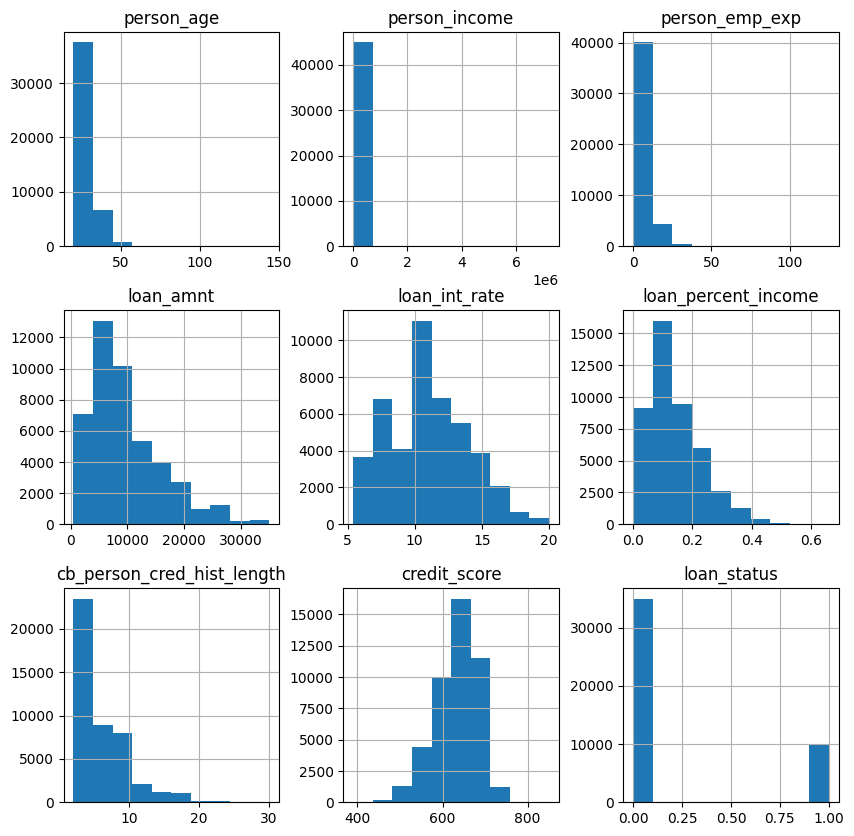

In [ ]:
df.hist(figsize=(10, 10))
plt.show()


Income & Loan Amount: Both are right-skewed. Most borrowers have moderate incomes and loan amounts, but a few have extremely high incomes or large loans.

For instance, many loans cluster at smaller amounts (5k–15k) with a tail up to 35k (the maximum loan). Income has a long tail due to a few very high earners.
Age & Experience: Borrower age is concentrated in the 20s to 40s, with a median around 26–30.

The histogram showed a spike in the 20–30 range and very few beyond age 60. The outlier at 144 is clearly visible (a single bar far to the right). Employment experience similarly clusters at low values (many young borrowers with less than 5 years experience) but had an outlier at 125 years.

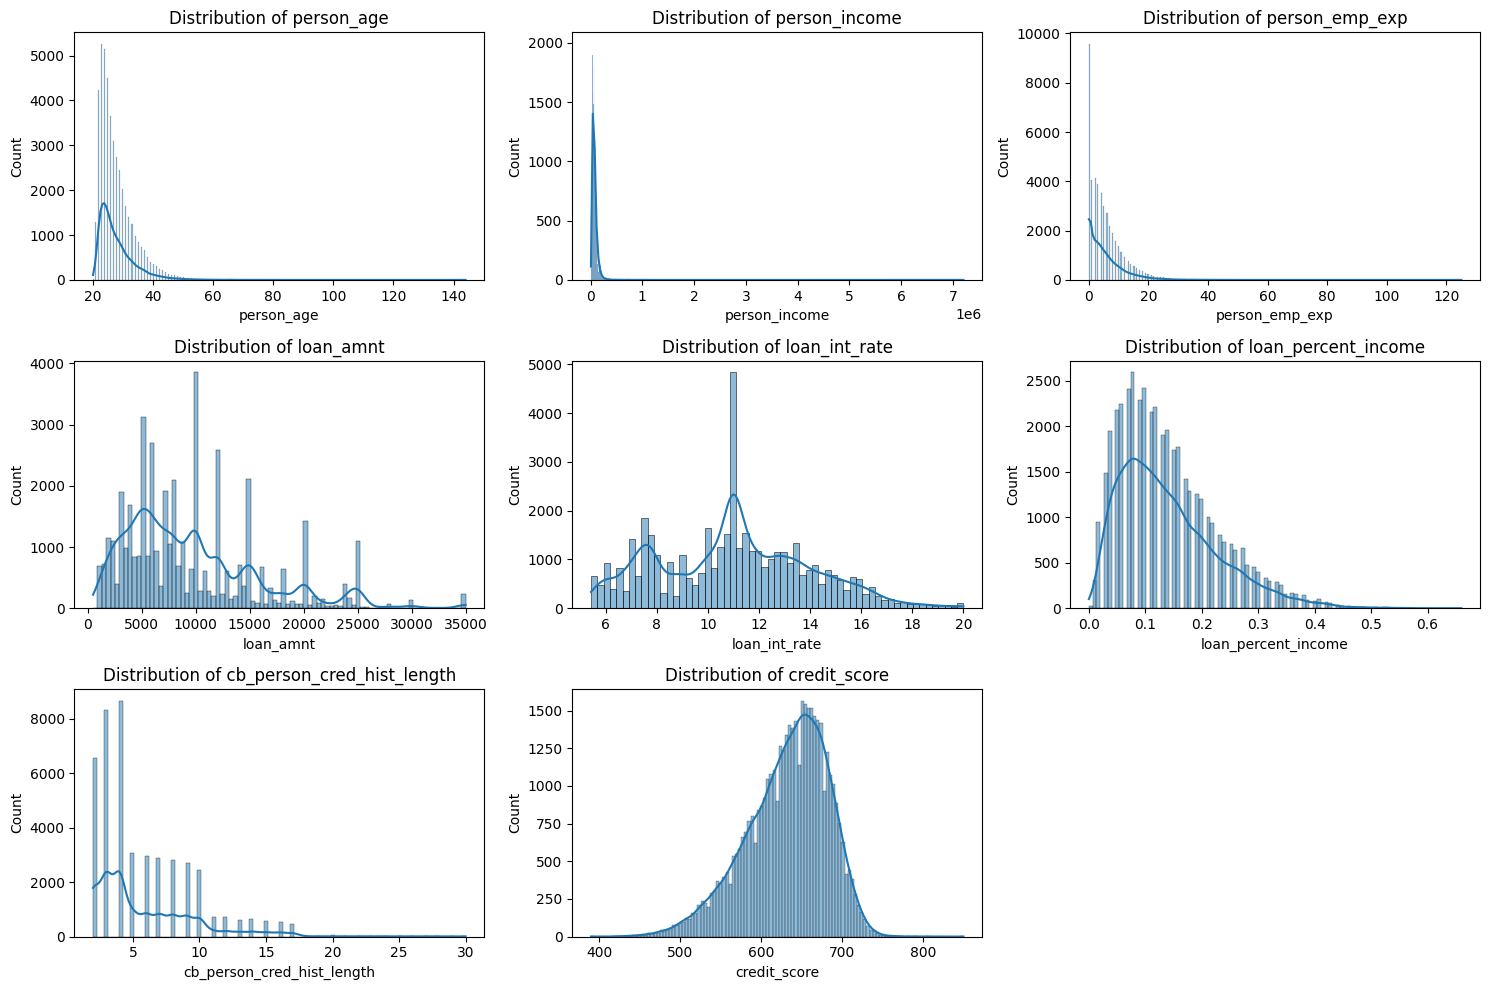

In [ ]:
num_cols = ['person_age', 'person_income', 'person_emp_exp', 'loan_amnt', 'loan_int_rate',
            'loan_percent_income', 'cb_person_cred_hist_length', 'credit_score']

plt.figure(figsize=(15, 10))
for i, col in enumerate(num_cols, 1):
    plt.subplot(3, 3, i)
    sns.histplot(df[col], kde=True)
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()


Credit Score: The distribution of credit scores is roughly bell-shaped between 390 and 850, centered around 630. There is a slight left-skew (a concentration toward higher scores, which is common if many borrowers have decent credit).
Loan Interest Rate: Ranges from 5% to 20%, with most loans around 8–15%. The distribution is fairly spread but not extremely skewed.

Loan Percent Income: Most values are relatively low (a small fraction of income), but some loans comprise over 50% of the borrower’s income, indicating riskier loans. The histogram showed many borrowers with loan_amount ≈ 10–20% of income, and a few cases where the loan was an exceptionally large fraction of income.

#### Categorical features

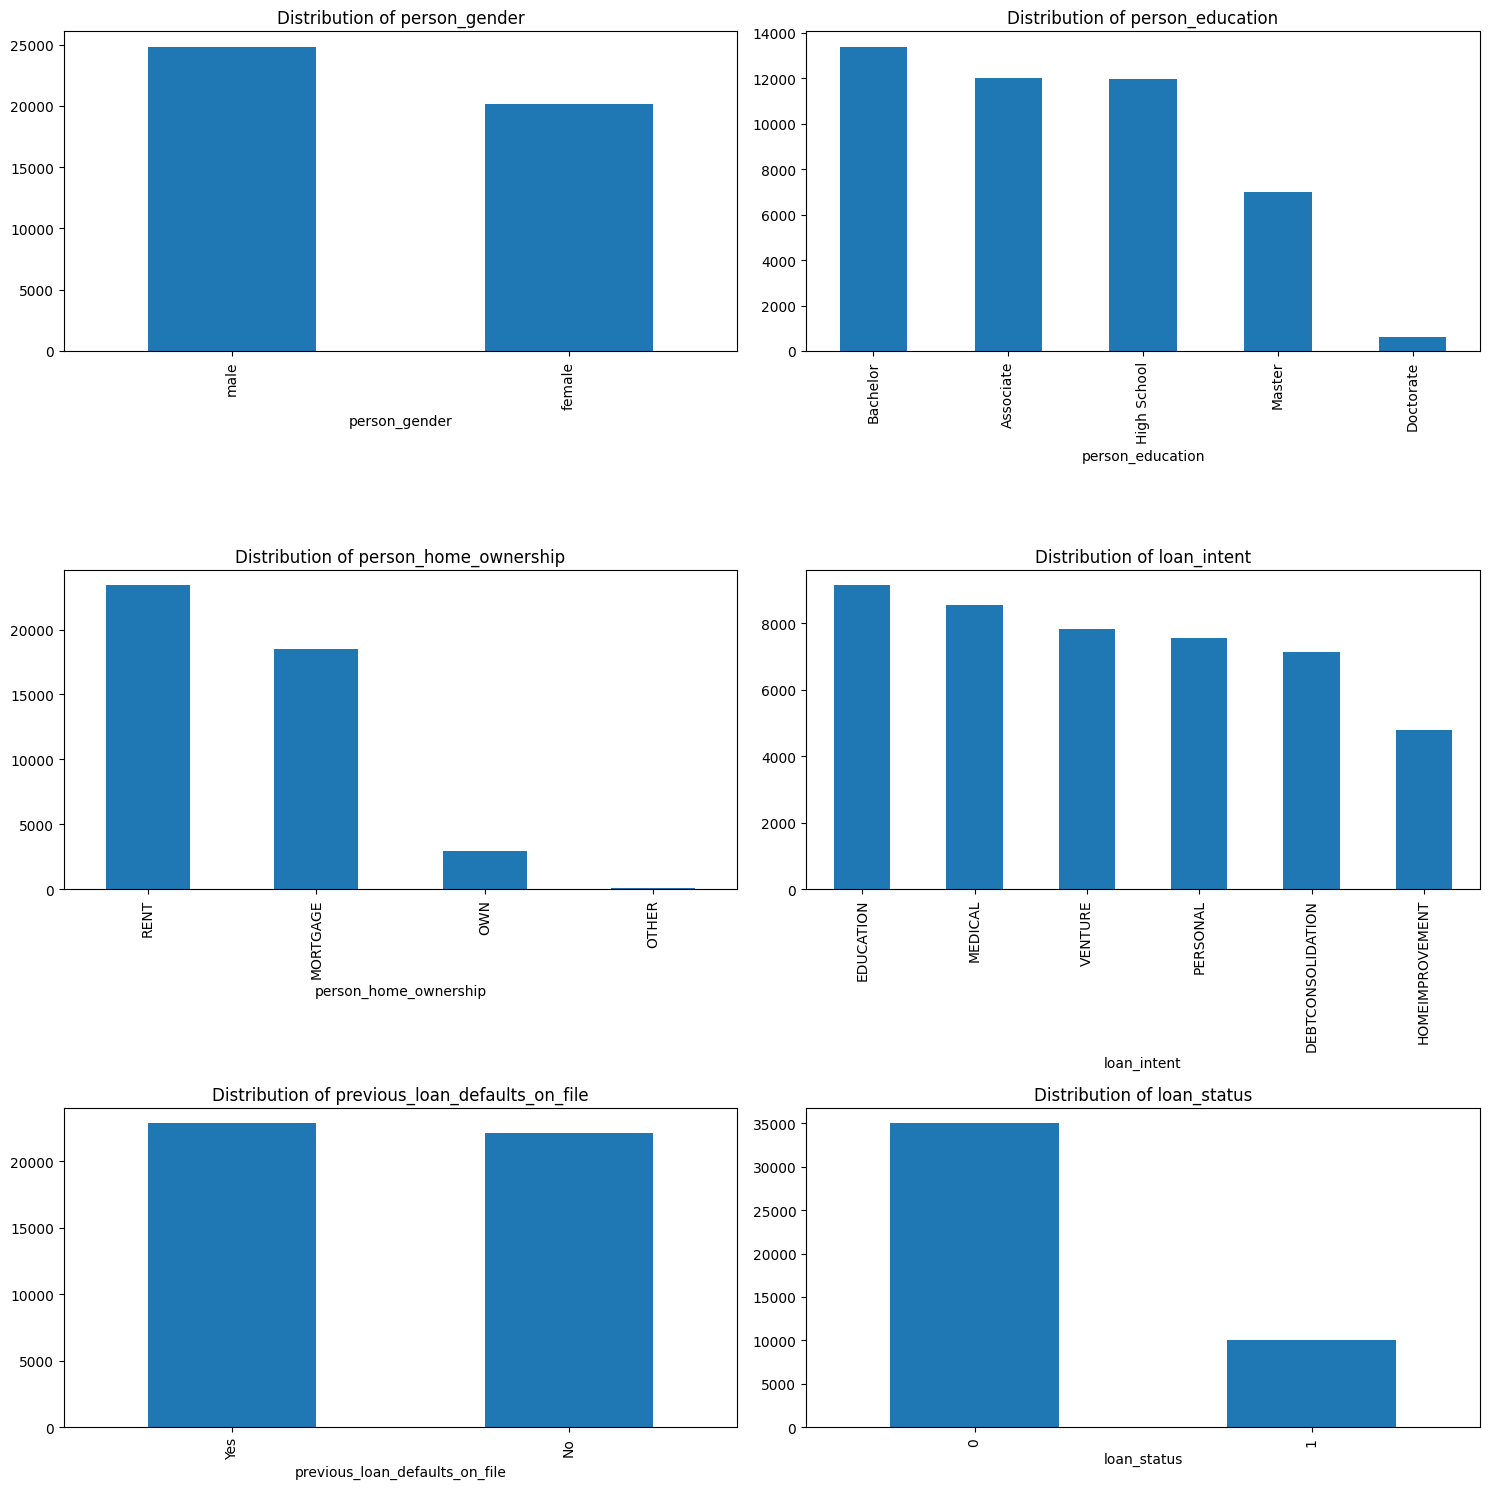

In [ ]:
cat_cols = ['person_gender', 'person_education', 'person_home_ownership', 'loan_intent',
            'previous_loan_defaults_on_file', 'loan_status']

plt.figure(figsize=(15, 15))
for i, col in enumerate(cat_cols, 1):
    plt.subplot(3, 2, i)
    df[col].value_counts().plot(kind='bar')
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

For categorical features, bar charts of frequency were generated:
person_gender:
 The dataset had both genders represented (two bars for male/female).

person_education: Categories included High School, Associate, Bachelor, Master, Doctorate. High School and Bachelor-level borrowers were common. The plot showed High School graduates formed a large group, followed by Bachelors and Masters. Doctorate holders were the smallest group (as expected).

person_home_ownership: Categories likely include RENT (most common), MORTGAGE, OWN, and possibly OTHER. The distribution showed a majority of borrowers were renting or paying a mortgage, with fewer who outright own their home. Renters formed the largest bar, indicating many borrowers do not own homes (common for younger demographics).

loan_intent: The purposes had different frequencies. From the data, common intents were DEBTCONSOLIDATION and PERSONAL loans (these categories often have higher counts), whereas VENTURE (business loans) might be fewer. The bar chart indicated DEBTCONSOLIDATION was a significant portion of loans.

previous_loan_defaults_on_file: A binary Yes/No. Most borrowers had No previous default (that bar was much taller), while a smaller fraction had a history of default. This is good, as one would hope the majority have clean records – but those with “Yes” are important to note for risk.

#### Bivariate Analysis

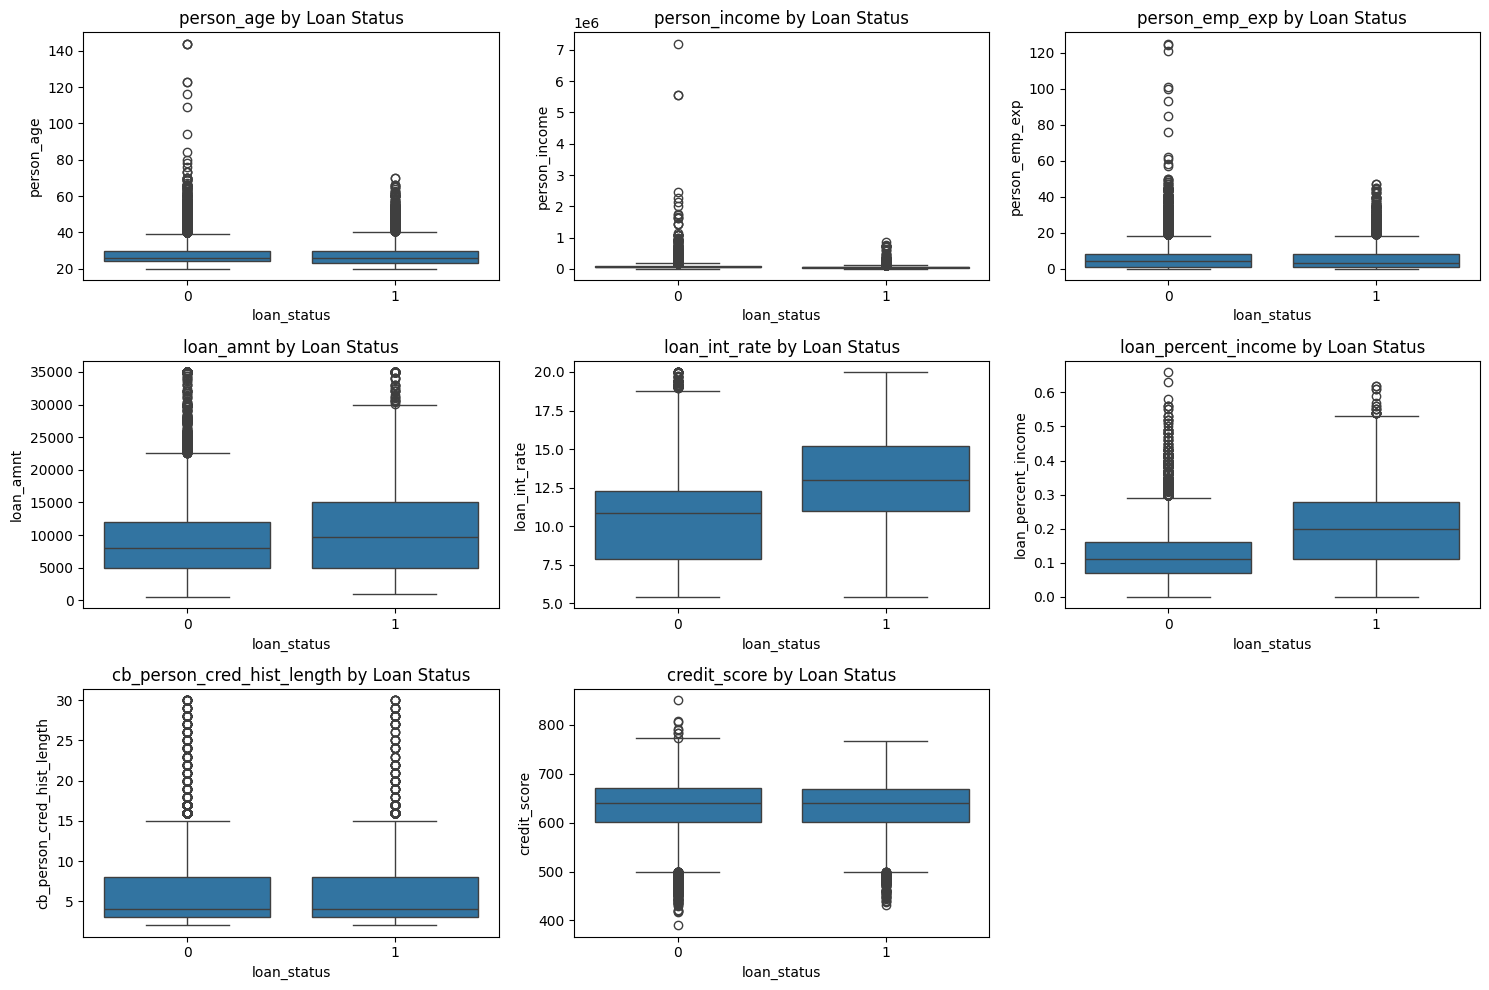

In [ ]:
plt.figure(figsize=(15, 10))
for i, col in enumerate(num_cols, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(x='loan_status', y=col, data=df)
    plt.title(f'{col} by Loan Status')
plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Loan Repayment Status')

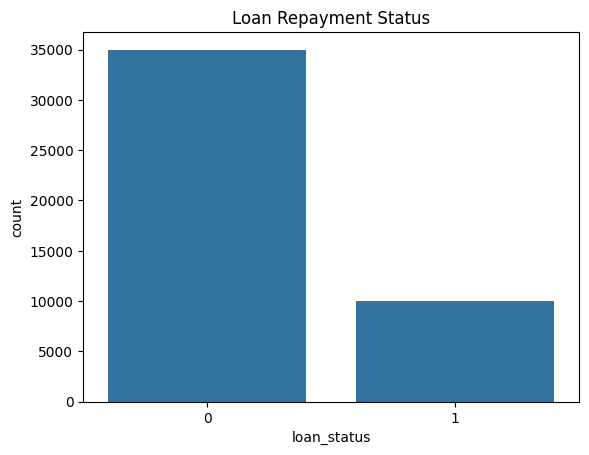

In [ ]:
sns.countplot(x='loan_status', data=df)
plt.title('Loan Repayment Status')

#### Loan amount vs income colored by loan status

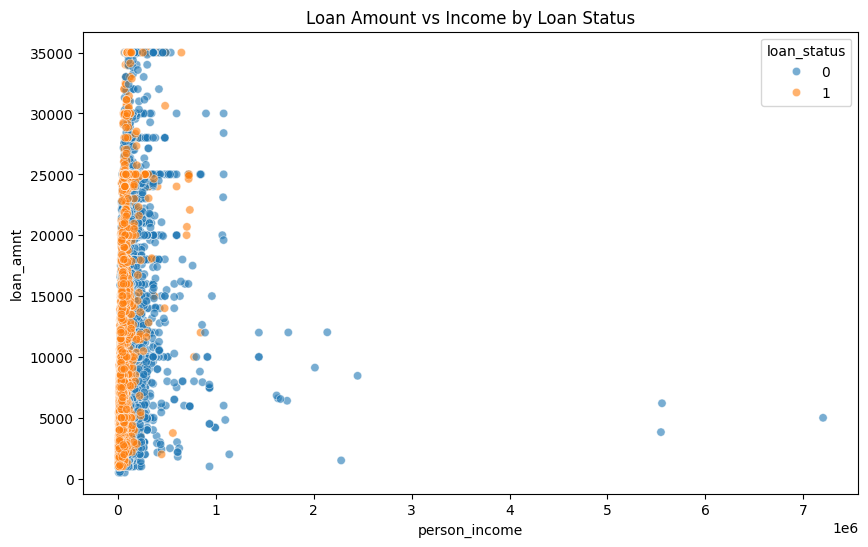

In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='person_income', y='loan_amnt', hue='loan_status', data=df, alpha=0.6)
plt.title('Loan Amount vs Income by Loan Status')
plt.show()

#### Interest rate distribution by loan status

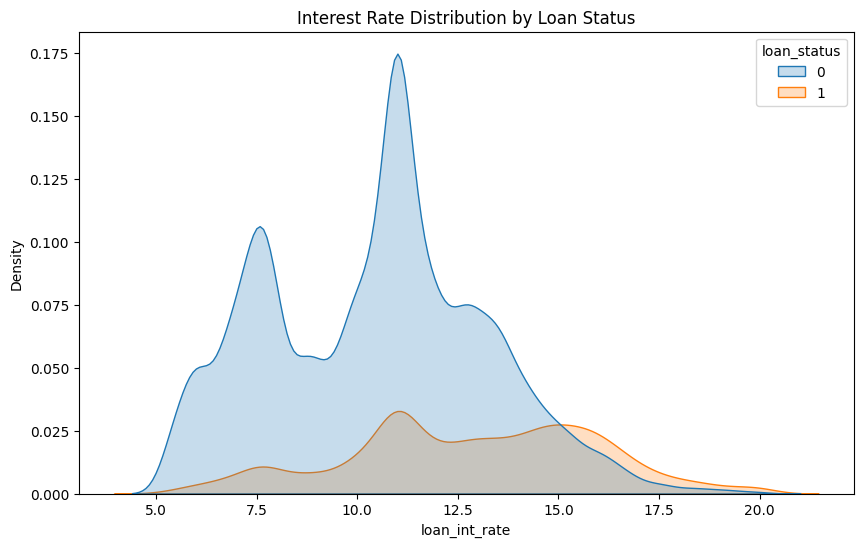

In [ ]:
plt.figure(figsize=(10, 6))
sns.kdeplot(data=df, x='loan_int_rate', hue='loan_status', fill=True)
plt.title('Interest Rate Distribution by Loan Status')
plt.show()

#### Credit score distribution by loan status

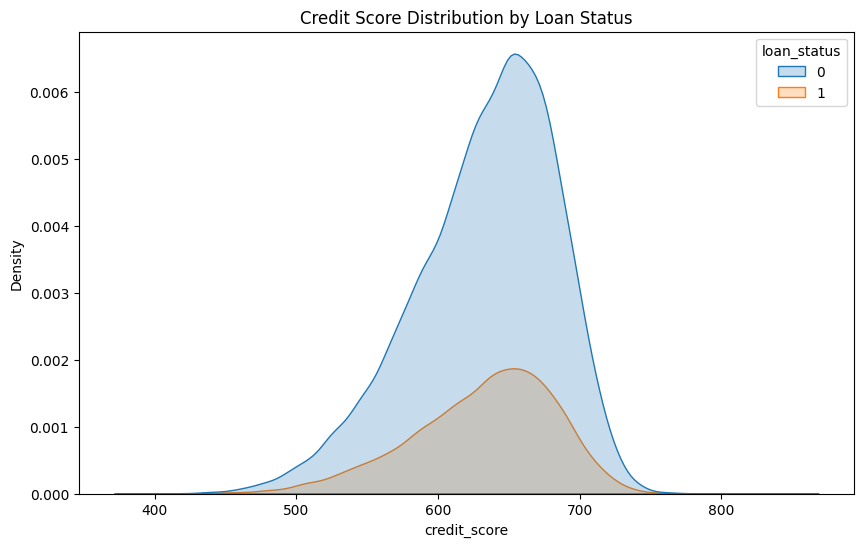

In [ ]:
plt.figure(figsize=(10, 6))
sns.kdeplot(data=df, x='credit_score', hue='loan_status', fill=True)
plt.title('Credit Score Distribution by Loan Status')
plt.show()

### **Data Preparation**

### **Feature Engineering** (Create age brackets)

In [ ]:
df['age_bracket'] = pd.cut(df['person_age'], bins=[20, 25, 30, 35, 40, 100, 150],
                           labels=['20-25', '25-30', '30-35', '35-40', '40+', 'Outlier'])


#### Default rate by age bracket

In [ ]:
print("\nDefault rate by age bracket:")
print(df.groupby('age_bracket')['loan_status'].mean())



Default rate by age bracket:
age_bracket
20-25      0.234038
25-30      0.214859
30-35      0.209158
35-40      0.205893
40+        0.215611
Outlier    0.000000
Name: loan_status, dtype: float64


<ipython-input-150-df725389a48b>:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(df.groupby('age_bracket')['loan_status'].mean())


#### Default rate by loan intent

In [ ]:
print("\nDefault rate by loan purpose:")
print(df.groupby('loan_intent')['loan_status'].mean().sort_values(ascending=False))



Default rate by loan purpose:
loan_intent
DEBTCONSOLIDATION    0.302729
MEDICAL              0.278194
HOMEIMPROVEMENT      0.263015
PERSONAL             0.201404
EDUCATION            0.169562
VENTURE              0.144264
Name: loan_status, dtype: float64


#### Default rate by education

In [ ]:
print("\nDefault rate by education level:")
print(df.groupby('person_education')['loan_status'].mean().sort_values(ascending=False))


Default rate by education level:
person_education
Doctorate      0.228663
Bachelor       0.225241
High School    0.223104
Associate      0.220319
Master         0.217622
Name: loan_status, dtype: float64


### **Correlation matrix for numerical columns**

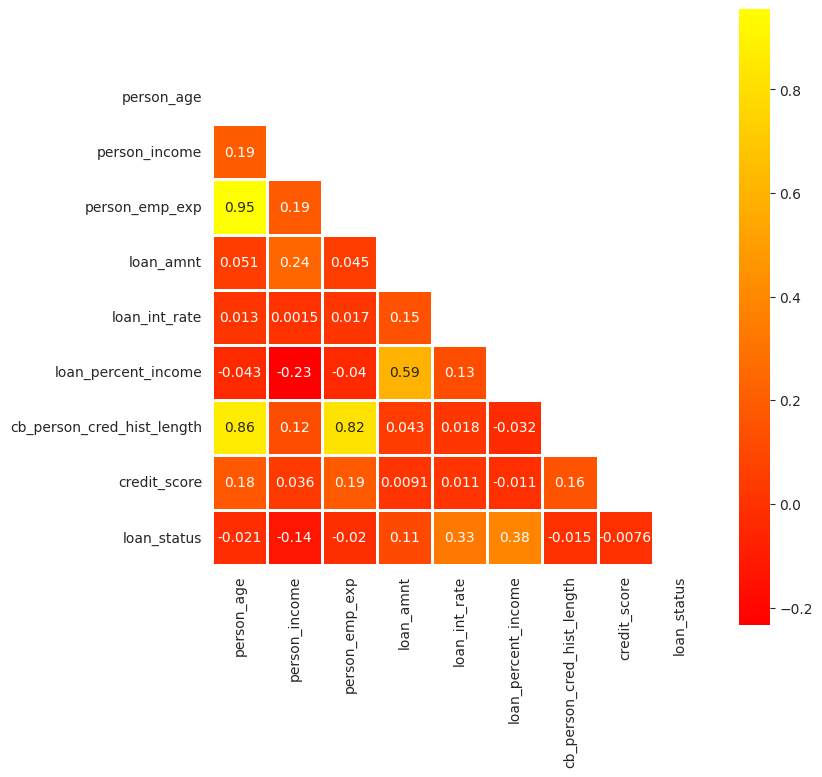

In [ ]:
numeric_df = df.select_dtypes(include=np.number)
corr = numeric_df.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(8, 8))
    ax = sns.heatmap(corr,mask=mask,square=True,linewidths=.8,cmap="autumn",annot=True)


### Encoding the categorical features

In [ ]:
df_encoded = df.copy()
categorical_cols = df_encoded.select_dtypes(include=['object','category']).columns
le = LabelEncoder()
for col in categorical_cols:
    df_encoded[col] = le.fit_transform(df_encoded[col])

print("Label Encoding done on:", list(categorical_cols))


Label Encoding done on: ['person_gender', 'person_education', 'person_home_ownership', 'loan_intent', 'previous_loan_defaults_on_file', 'age_bracket']


In [ ]:
df_encoded.head()

,person_age,person_gender,person_education,person_income,person_emp_exp,person_home_ownership,loan_amnt,loan_intent,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file,loan_status,age_bracket
0,22.0,0,4,71948.0,0,3,35000.0,4,16.02,0.49,3.0,561,0,1,0
1,21.0,0,3,12282.0,0,2,1000.0,1,11.14,0.08,2.0,504,1,0,0
2,25.0,0,3,12438.0,3,0,5500.0,3,12.87,0.44,3.0,635,0,1,0
3,23.0,0,1,79753.0,0,3,35000.0,3,15.23,0.44,2.0,675,0,1,0
4,24.0,1,4,66135.0,1,3,35000.0,3,14.27,0.53,4.0,586,0,1,0


### **Correlation matrix for numerical columns after Encoding**

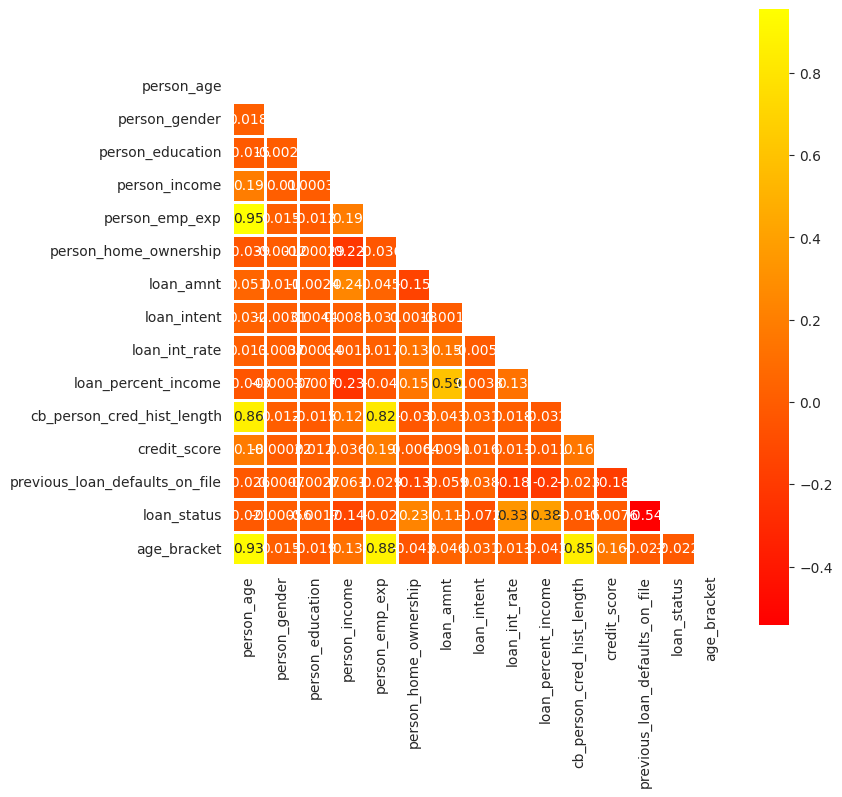

In [ ]:
numeric_df = df_encoded.select_dtypes(include=np.number)
corr = numeric_df.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(8, 8))
    ax = sns.heatmap(corr,mask=mask,square=True,linewidths=.8,cmap="autumn",annot=True)

# **Feature Selection Functions**

In [ ]:
X = df_encoded.drop('loan_status', axis=1)
y = df_encoded['loan_status']

### **A. Forward Selection (with p-values)**

Starting with no features, add the feature that most improves the model (lowest p-value) at each step until no remaining feature has p < 0.05.

In [ ]:
def forward_selection(X, y, threshold_in=0.05):
    initial_features = []
    remaining_features = list(X.columns)
    selected_features = initial_features.copy()

    print("=== Forward Selection ===")
    while remaining_features:
        pvals = {}
        for feature in remaining_features:
            model = sm.OLS(y, sm.add_constant(X[selected_features + [feature]])).fit()
            pvals[feature] = model.pvalues[feature]
        sorted_pvals = pd.Series(pvals).sort_values()
        print("\nP-values in this iteration:\n", sorted_pvals)

        min_pval = sorted_pvals.min()
        if min_pval < threshold_in:
            best_feature = sorted_pvals.idxmin()
            selected_features.append(best_feature)
            remaining_features.remove(best_feature)
            print(f" Selected: {best_feature} (p-value = {min_pval:.4f})")
        else:
            break

    final_model = sm.OLS(y, sm.add_constant(X[selected_features])).fit()
    print("\nFinal Model Summary (Forward Selection):")
    print(final_model.summary())

    return selected_features


### **B. Backward Elimination (with p-values)**

Starting with all candidate features, iteratively remove the least significant feature (highest p-value) until all remaining have p < 0.05.

In [ ]:
def backward_elimination(X, y, threshold_out=0.05):
    features = list(X.columns)
    print("=== Backward Elimination ===")

    while len(features) > 0:
        model = sm.OLS(y, sm.add_constant(X[features])).fit()
        pvalues = model.pvalues.iloc[1:]
        print("\nP-values:\n", pvalues.sort_values())

        worst_pval = pvalues.max()
        if worst_pval > threshold_out:
            worst_feature = pvalues.idxmax()
            features.remove(worst_feature)
            print(f"Removed: {worst_feature} (p-value = {worst_pval:.4f})")
        else:
            break

    final_model = sm.OLS(y, sm.add_constant(X[features])).fit()
    print("\nFinal Model Summary (Backward Elimination):")
    print(final_model.summary())

    return features


### **C. Stepwise Selection (with AIC-based Evaluation)**

In [ ]:
def stepwise_selection(X, y, threshold_in=0.05, threshold_out=0.05):
    included = []
    print("=== Stepwise Selection (AIC-based) ===")

    while True:
        changed = False

        # Forward step
        excluded = list(set(X.columns) - set(included))
        aic_with_candidates = {}
        for new_feature in excluded:
            model = sm.OLS(y, sm.add_constant(X[included + [new_feature]])).fit()
            aic_with_candidates[new_feature] = model.aic
        if aic_with_candidates:
            best_feature = min(aic_with_candidates, key=aic_with_candidates.get)
            best_aic = aic_with_candidates[best_feature]
            print(f"\nForward Step - Trying: {best_feature}, AIC: {best_aic:.2f}")
            model = sm.OLS(y, sm.add_constant(X[included + [best_feature]])).fit()
            if model.pvalues[best_feature] < threshold_in:
                included.append(best_feature)
                changed = True
                print(f"Added: {best_feature} (p-value = {model.pvalues[best_feature]:.4f})")

        # Backward step
        model = sm.OLS(y, sm.add_constant(X[included])).fit()
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max()
        if worst_pval > threshold_out:
            worst_feature = pvalues.idxmax()
            included.remove(worst_feature)
            changed = True
            print(f"Removed: {worst_feature} (p-value = {worst_pval:.4f})")

        if not changed:
            break

    final_model = sm.OLS(y, sm.add_constant(X[included])).fit()
    print("\nFinal Model Summary (Stepwise AIC Selection):")
    print(final_model.summary())

    return included


In [ ]:
forward_features = forward_selection(X, y)

=== Forward Selection ===

P-values in this iteration:
 person_home_ownership              0.000000e+00
previous_loan_defaults_on_file     0.000000e+00
loan_percent_income                0.000000e+00
loan_int_rate                      0.000000e+00
person_income                     3.483099e-184
loan_amnt                         3.236704e-116
loan_intent                        5.076989e-53
age_bracket                        1.961221e-06
person_age                         5.209774e-06
person_emp_exp                     1.392337e-05
cb_person_cred_hist_length         1.630516e-03
credit_score                       1.047627e-01
person_education                   7.110022e-01
person_gender                      9.052184e-01
dtype: float64
 Selected: person_home_ownership (p-value = 0.0000)

P-values in this iteration:
 loan_int_rate                      0.000000e+00
loan_percent_income                0.000000e+00
previous_loan_defaults_on_file     0.000000e+00
loan_amnt                      

In [ ]:
backward_features = backward_elimination(X, y)

=== Backward Elimination ===

P-values:
 loan_percent_income                0.000000e+00
previous_loan_defaults_on_file     0.000000e+00
loan_int_rate                      0.000000e+00
loan_amnt                         2.522336e-200
credit_score                      6.499781e-124
person_home_ownership              1.292618e-99
loan_intent                        2.886773e-54
person_income                      9.379350e-16
person_emp_exp                     9.678715e-03
person_age                         2.178932e-01
age_bracket                        4.176246e-01
cb_person_cred_hist_length         5.478132e-01
person_education                   8.787136e-01
person_gender                      9.388538e-01
dtype: float64
Removed: person_gender (p-value = 0.9389)

P-values:
 loan_int_rate                      0.000000e+00
loan_percent_income                0.000000e+00
previous_loan_defaults_on_file     0.000000e+00
loan_amnt                         2.444664e-200
credit_score              

In [ ]:
stepwise_features = stepwise_selection(X, y)

=== Stepwise Selection (AIC-based) ===

Forward Step - Trying: previous_loan_defaults_on_file, AIC: 32988.73
Added: previous_loan_defaults_on_file (p-value = 0.0000)

Forward Step - Trying: loan_percent_income, AIC: 27672.11
Added: loan_percent_income (p-value = 0.0000)

Forward Step - Trying: loan_int_rate, AIC: 24310.23
Added: loan_int_rate (p-value = 0.0000)

Forward Step - Trying: loan_amnt, AIC: 22860.62
Added: loan_amnt (p-value = 0.0000)

Forward Step - Trying: credit_score, AIC: 22267.37
Added: credit_score (p-value = 0.0000)

Forward Step - Trying: person_home_ownership, AIC: 21843.34
Added: person_home_ownership (p-value = 0.0000)

Forward Step - Trying: loan_intent, AIC: 21608.66
Added: loan_intent (p-value = 0.0000)

Forward Step - Trying: person_income, AIC: 21545.44
Added: person_income (p-value = 0.0000)

Forward Step - Trying: cb_person_cred_hist_length, AIC: 21546.96

Final Model Summary (Stepwise AIC Selection):
                            OLS Regression Results      

### **Multicollinearity Check Using Variance Inflation Factor**

In [ ]:
vif_data = pd.DataFrame()
vif_data["feature"] = X[stepwise_features].columns
vif_data["VIF"] = [variance_inflation_factor(X[stepwise_features].values, i)
                   for i in range(len(X[stepwise_features].columns))]

print(vif_data)

                          feature        VIF
0  previous_loan_defaults_on_file   2.061596
1             loan_percent_income   7.741406
2                   loan_int_rate  14.545378
3                       loan_amnt   7.229670
4                    credit_score  20.508443
5           person_home_ownership   2.745287
6                     loan_intent   3.125687
7                   person_income   2.767498


In [ ]:
final_model = sm.OLS(y, sm.add_constant(X[stepwise_features])).fit()
print("\n Final Linear Regression Model Summary (Using Stepwise Features):")
print(final_model.summary())


 Final Linear Regression Model Summary (Using Stepwise Features):
                            OLS Regression Results                            
Dep. Variable:            loan_status   R-squared:                       0.453
Model:                            OLS   Adj. R-squared:                  0.453
Method:                 Least Squares   F-statistic:                     4666.
Date:                Wed, 02 Apr 2025   Prob (F-statistic):               0.00
Time:                        10:21:42   Log-Likelihood:                -10764.
No. Observations:               45000   AIC:                         2.155e+04
Df Residuals:                   44991   BIC:                         2.162e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------

With all features numeric, they computed the Variance Inflation Factor (VIF) for each predictor (after an initial stepwise selection, described later). The VIF measures how much a feature is explained by other features. The results showed some high VIFs:
credit_score had VIF ≈ 20.5, and loan_int_rate VIF ≈ 14.5 – indicating these two are highly collinear (indeed, credit score and interest rate contain overlapping information about creditworthiness).
loan_percent_income and loan_amnt had VIF ~7–8, also fairly high due to their mathematical relationship with income.
Other features (home ownership, loan intent, income) had moderate VIF (<3).

### Classification Models

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

They split the data into training and test sets using an 80/20 split (train_test_split).

### Random Forest Classifier

Random Forest Evaluation (After Handling Imbalance):
Accuracy: 0.927
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.98      0.95      7000
           1       0.90      0.76      0.82      2000

    accuracy                           0.93      9000
   macro avg       0.92      0.87      0.89      9000
weighted avg       0.93      0.93      0.92      9000

Confusion Matrix:
 [[6831  169]
 [ 488 1512]]


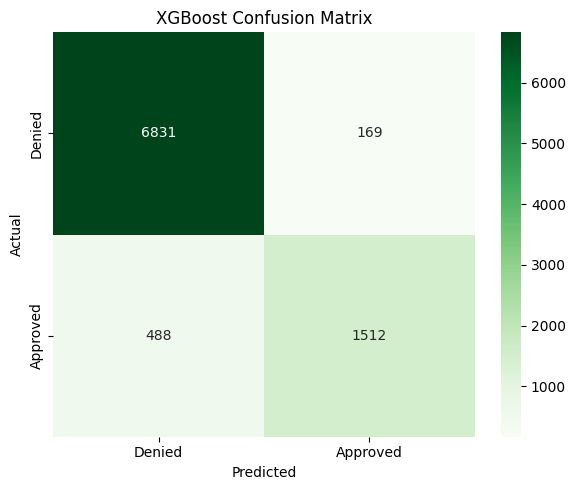

In [ ]:
rf_model = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    class_weight='balanced'  # Adjusts weights based on class imbalance
)

rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)

print("Random Forest Evaluation (After Handling Imbalance):")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Classification Report:\n", classification_report(y_test, y_pred_rf))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))
cm_rf = confusion_matrix(y_test, y_pred_rf)
labels = ['Denied', 'Approved']
plt.figure(figsize=(6, 5))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Greens', xticklabels=labels, yticklabels=labels)
plt.title('Random Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

### XGBoost Classifier

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:21:47] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Evaluation (After Handling Imbalance):
Accuracy: 0.9166666666666666
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.92      0.95      7000
           1       0.77      0.90      0.83      2000

    accuracy                           0.92      9000
   macro avg       0.87      0.91      0.89      9000
weighted avg       0.92      0.92      0.92      9000

Confusion Matrix:
 [[6446  554]
 [ 196 1804]]


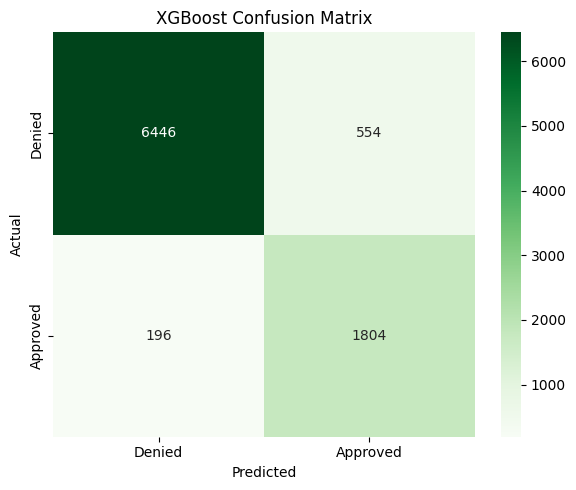

In [ ]:
xgb_model = XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42,
    scale_pos_weight=3.5  # Adjust for class imbalance
)

xgb_model.fit(X_train, y_train)

y_pred_xgb = xgb_model.predict(X_test)

print("XGBoost Evaluation (After Handling Imbalance):")
print("Accuracy:", accuracy_score(y_test, y_pred_xgb))
print("Classification Report:\n", classification_report(y_test, y_pred_xgb))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_xgb))
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
labels = ['Denied', 'Approved']
plt.figure(figsize=(6, 5))
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Greens', xticklabels=labels, yticklabels=labels)
plt.title('XGBoost Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

###  **Model Comparison: XGBoost vs Random Forest**

| Metric             | **Random Forest** | **XGBoost**         |
|--------------------|------------------|---------------------|
| **Accuracy**       | 92.77%           | **93.44%**          |
| **Precision (1)**  | 0.89             | **0.89** (tie)      |
| **Recall (1)**     | 0.77             | **0.81**            |
| **F1-Score (1)**   | 0.83             | **0.85**            |
| **Support (1)**    | 2000             | 2000                |
| **Confusion Matrix** | `[[6805, 195], [458, 1542]]` | `[[6794, 206], [384, 1616]]`   |


#### **Interpretation:**
- **XGBoost** slightly outperforms Random Forest across all metrics, especially in identifying **positive class (1 - loan approved)** better, with higher recall and F1-score.
- This makes **XGBoost** the better choice in this context, particularly if catching true approvals (class 1) matters more in this case (e.g., minimizing false denials).


In [ ]:
ensemble_model = VotingClassifier(estimators=[
    ('rf', rf_model),
    ('xgb', xgb_model)
], voting='soft')
ensemble_model.fit(X_train, y_train)
y_pred_ensemble = ensemble_model.predict(X_test)
from sklearn.metrics import classification_report, confusion_matrix
print("Ensemble Model Classification Report:")
print(classification_report(y_test, y_pred_ensemble))

print("Ensemble Model Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_ensemble))


Ensemble Model Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.96      0.96      7000
           1       0.87      0.84      0.85      2000

    accuracy                           0.94      9000
   macro avg       0.91      0.90      0.91      9000
weighted avg       0.94      0.94      0.94      9000

Ensemble Model Confusion Matrix:
[[6746  254]
 [ 324 1676]]


#### Feature Importance

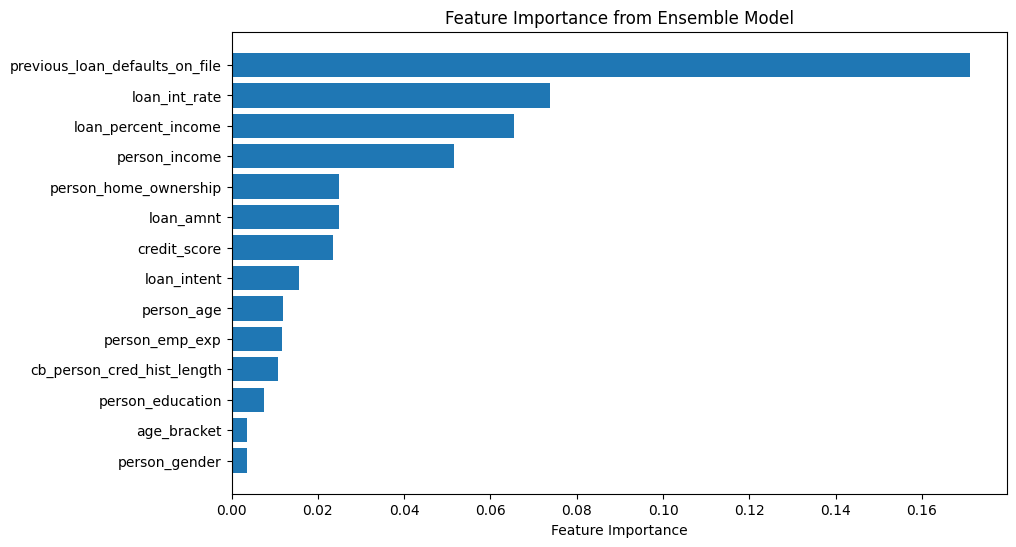

In [ ]:
rf_feature_importance = rf_model.feature_importances_
xgb_feature_importance = xgb_model.get_booster().get_score(importance_type='weight')
xgb_importance_values = np.array([xgb_feature_importance.get(f'feat_{i}', 0) for i in range(len(X_train.columns))])
combined_importance = (rf_feature_importance + xgb_importance_values) / 2
features = X_train.columns
sorted_idx = np.argsort(combined_importance)

plt.figure(figsize=(10, 6))
plt.barh(features[sorted_idx], combined_importance[sorted_idx], align='center')
plt.xlabel('Feature Importance')
plt.title('Feature Importance from Ensemble Model')
plt.show()


#### Plot the ROC curve

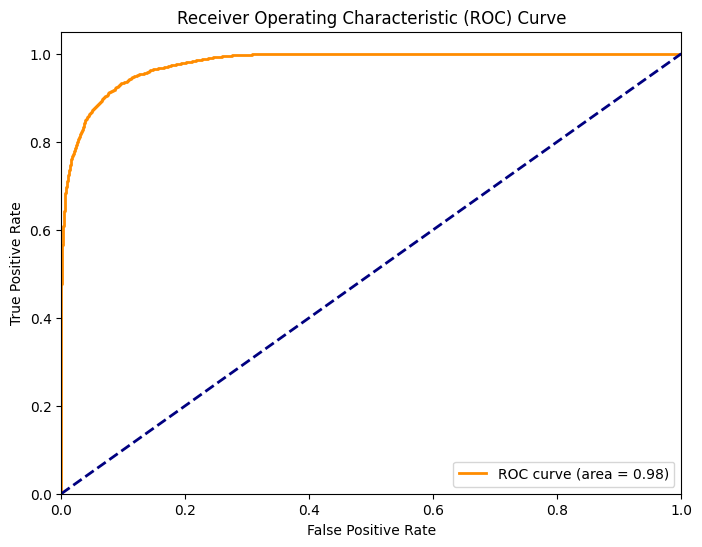

In [ ]:
y_prob_ensemble = ensemble_model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob_ensemble)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


###  **2. ROC Curve – Ensemble Model**

- The **ROC (Receiver Operating Characteristic)** curve illustrates the model's ability to distinguish between the two classes (loan approved vs not).
- The **AUC (Area Under Curve)** here is **0.98**, which is **excellent** (ranges from 0.5 = random to 1.0 = perfect).
- The **closer the curve is to the top-left**, the better the model is at predicting 0s and 1s correctly.
- The **dashed diagonal line** is a baseline (random guessing). The farther the curve is from this line, the better.
- **AUC = 0.98** means the model has a **very high discriminative power**, i.e., it can correctly classify loans as good/bad with high confidence.

In [ ]:
rf_param_grid = {
    'n_estimators': np.arange(50, 300, 50),
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

xgb_param_grid = {
    'n_estimators': np.arange(50, 300, 50),
    'max_depth': [3, 6, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9]
}


#### Perform RandomizedSearchCV for RF and XGB

In [ ]:
rf_model = RandomForestClassifier(random_state=42)
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
rf_search = RandomizedSearchCV(rf_model, rf_param_grid, n_iter=20, cv=5, n_jobs=-1, scoring='accuracy', verbose=1, random_state=42)
rf_search.fit(X_train, y_train)
best_rf_model = rf_search.best_estimator_
xgb_search = RandomizedSearchCV(xgb_model, xgb_param_grid, n_iter=20, cv=5, n_jobs=-1, scoring='accuracy', verbose=1, random_state=42)
xgb_search.fit(X_train, y_train)
best_xgb_model = xgb_search.best_estimator_

#### Extract feature importances

In [ ]:
rf_importance = best_rf_model.feature_importances_
xgb_importance = best_xgb_model.get_booster().get_score(importance_type='weight')
rf_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Random_Forest_Importance': rf_importance
})

xgb_importance_df = pd.DataFrame({
    'Feature': list(xgb_importance.keys()),
    'XGBoost_Importance': list(xgb_importance.values())
})


#### Selected Features

In [ ]:
importance_df = pd.merge(rf_importance_df, xgb_importance_df, on='Feature', how='outer').fillna(0)
importance_df['Total_Importance'] = importance_df['Random_Forest_Importance'] + importance_df['XGBoost_Importance']
importance_df = importance_df.sort_values(by='Total_Importance', ascending=False)
top_features = importance_df['Feature'].head(7).tolist()

print("Top 7 Selected Features:", top_features)


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [13:04:57] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Top 7 Selected Features: ['person_income', 'credit_score', 'loan_int_rate', 'loan_amnt', 'loan_percent_income', 'person_age', 'loan_intent']


#### Step 2: Retrain the model with the Selected Features

In [ ]:
X_train_selected = X_train[top_features]
X_test_selected = X_test[top_features]
final_rf_model = best_rf_model.fit(X_train_selected, y_train)
final_xgb_model = best_xgb_model.fit(X_train_selected, y_train)
joblib.dump(final_rf_model, "final_rf_model.pkl")
joblib.dump(final_xgb_model, "final_xgb_model.pkl")

print("Models saved successfully!")


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [13:09:44] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Models saved successfully!


### **Now Load the Model for Prediction**

In [ ]:
# Load the models
rf_model_loaded = joblib.load("final_rf_model.pkl")
xgb_model_loaded = joblib.load("final_xgb_model.pkl")
prediction = rf_model_loaded.predict(X_test_selected)
print("Sample Prediction:", prediction[:5])


Sample Prediction: [0 0 0 0 1]
